Source:

handling imbalanced dataset problem

https://www.linkedin.com/pulse/some-tricks-handling-imbalanced-dataset-image-m-farhan-tandia/ 

https://stackoverflow.com/questions/66016844/imbalanced-image-dataset-tensorflow2

https://stackoverflow.com/questions/41648129/balancing-an-imbalanced-dataset-with-keras-image-generator


Getting images off Google

https://pypi.org/project/Google-Images-Search/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

In [2]:
print(tf.test.is_gpu_available)

<function is_gpu_available at 0x0000022CEA293F70>


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
import os

In [5]:
print(os.getcwd())

C:\Users\Randy\GitHub\metamo


In [6]:
train_root = os.path.join(os.getcwd(),'train')
test_root = os.path.join(os.getcwd(),'test')
emotions = ['angry','disgust','fear','happy','neutral','sad','surprise']

In [7]:
for emotion in emotions:
    f_name = os.listdir(os.path.join(train_root,emotion))
    print(emotion , ' has \t', len(f_name), ' number of files')

angry  has 	 3995  number of files
disgust  has 	 436  number of files
fear  has 	 4097  number of files
happy  has 	 7215  number of files
neutral  has 	 4965  number of files
sad  has 	 4830  number of files
surprise  has 	 3171  number of files


In [8]:
seed_num = 42

train_dataGen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255,
                                                                vertical_flip= True, 
                                                                rotation_range=5,
                                                                width_shift_range=0.2,
                                                                height_shift_range=0.2,
                                                                shear_range=0.2,
                                                                horizontal_flip=True,
                                                                fill_mode='nearest')

train_dataflow = train_dataGen.flow_from_directory(train_root,
                                                  target_size = (48,48),
                                                  color_mode = 'grayscale',
                                                  seed = seed_num)

test_dataGen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

test_dataflow = test_dataGen.flow_from_directory(test_root,
                                                target_size=(48,48),
                                                color_mode= 'grayscale',
                                                shuffle = False,
                                                seed = seed_num)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [10]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, log={}):
        if (log['acc'] > log['val_acc'] + 0.2) and (epoch > 25):
            print('\n Train acc much greater than val acc. Training stopped')
            self.model.stop_training = True
            
myCallback = myCallback()

In [11]:
early_callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                                                  restore_best_weights= True, 
                                                  monitor = 'val_acc')

In [18]:
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_acc', patience = 5)

In [54]:
CNN_v1_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3) , input_shape = (48,48,1), activation = 'relu'),
    tf.keras.layers.Conv2D(128, (3,3) , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3,3) , activation = 'relu'),
    tf.keras.layers.Conv2D(512, (3,3) , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])

In [55]:
# CNN_v1_model.compile(loss = 'sparse_categorical_crossentropy' , 
#               metrics = ['acc'],
#              optimizer = tf.keras.optimizers.RMSprop())

CNN_v1_model.compile(loss = 'categorical_crossentropy' , 
              metrics = ['acc'],
             optimizer = tf.keras.optimizers.RMSprop())

In [56]:
CNN_v1_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 conv2d_9 (Conv2D)           (None, 44, 44, 128)       73856     
                                                                 
 batch_normalization_4 (Batc  (None, 44, 44, 128)      512       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 22, 22, 128)      0         
 2D)                                                             
                                                                 
 dropout_5 (Dropout)         (None, 22, 22, 128)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 20, 20, 256)      

In [60]:
#CNN_v1_model.load_weights('CNN_v1_250epochs.h5')
epochs = 10
steps_per_epoch = 1000

CNN_v1_history = CNN_v1_model.fit(train_dataflow, 
                                  epochs = epochs, 
                                  validation_data=(test_dataflow),
                                  #steps_per_epoch=steps_per_epoch,
                                  callbacks=[early_callback, myCallback, reduceLR])

Epoch 1/10
898/898 [==============================] - 36s 39ms/step - loss: 3.5926 - acc: 0.2513 - val_loss: 1.7161 - val_acc: 0.2938 - lr: 0.0010
Epoch 2/10
898/898 [==============================] - 34s 38ms/step - loss: 1.6985 - acc: 0.3050 - val_loss: 1.7132 - val_acc: 0.3052 - lr: 0.0010
Epoch 3/10
898/898 [==============================] - 35s 39ms/step - loss: 1.6468 - acc: 0.3343 - val_loss: 1.8042 - val_acc: 0.2850 - lr: 0.0010
Epoch 4/10
898/898 [==============================] - 35s 39ms/step - loss: 1.5998 - acc: 0.3655 - val_loss: 1.7709 - val_acc: 0.3626 - lr: 0.0010
Epoch 5/10
898/898 [==============================] - 35s 38ms/step - loss: 1.5511 - acc: 0.3893 - val_loss: 1.6464 - val_acc: 0.3963 - lr: 0.0010
Epoch 6/10
898/898 [==============================] - 34s 38ms/step - loss: 1.5235 - acc: 0.4045 - val_loss: 1.6248 - val_acc: 0.3816 - lr: 0.0010
Epoch 7/10
898/898 [==============================] - 35s 38ms/step - loss: 1.5000 - acc: 0.4209 - val_loss: 1.4316 - 

In [61]:
def plot_results(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc  =history.history['val_acc']
    
    length = range(len(loss))
    
    plt.plot(length, loss, 'b' ,label = 'Training Loss')
    plt.plot(length, val_loss, 'r--', label = 'Validation Loss')
    plt.title('Training vs Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure()
    
    plt.plot(length, acc, 'b' ,label = 'Training Acc')
    plt.plot(length, val_acc, 'r--', label = 'Validation Acc')
    plt.title('Training vs Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

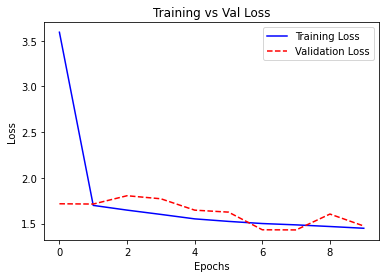

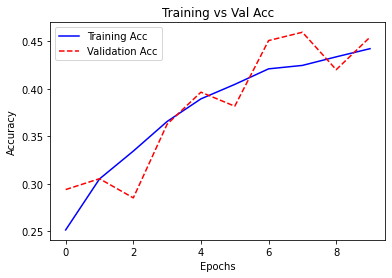

In [62]:
plot_results(CNN_v1_history)

This looks promising. We train for a further 90 epochs, totalling 100 epochs for this model

In [63]:
epochs = 100
steps_per_epoch = 1000

CNN_v1_history = CNN_v1_model.fit(train_dataflow, 
                                  epochs = epochs, 
                                  validation_data=(test_dataflow),
                                  initial_epoch = 10,
                                  #steps_per_epoch=steps_per_epoch,
                                  callbacks=[early_callback, myCallback, reduceLR])

Epoch 11/100
898/898 [==============================] - 35s 39ms/step - loss: 1.4413 - acc: 0.4465 - val_loss: 1.4339 - val_acc: 0.4592 - lr: 0.0010
Epoch 12/100
898/898 [==============================] - 35s 38ms/step - loss: 1.4307 - acc: 0.4550 - val_loss: 1.4052 - val_acc: 0.4604 - lr: 0.0010
Epoch 13/100
898/898 [==============================] - 34s 38ms/step - loss: 1.4217 - acc: 0.4560 - val_loss: 1.6059 - val_acc: 0.4186 - lr: 0.0010
Epoch 14/100
898/898 [==============================] - 34s 38ms/step - loss: 1.4066 - acc: 0.4610 - val_loss: 1.4756 - val_acc: 0.4419 - lr: 0.0010
Epoch 15/100
898/898 [==============================] - 43s 48ms/step - loss: 1.4014 - acc: 0.4643 - val_loss: 1.4324 - val_acc: 0.4611 - lr: 0.0010
Epoch 16/100
898/898 [==============================] - 34s 38ms/step - loss: 1.3919 - acc: 0.4718 - val_loss: 1.3811 - val_acc: 0.4822 - lr: 0.0010
Epoch 17/100
898/898 [==============================] - 44s 49ms/step - loss: 1.3827 - acc: 0.4750 - val_l

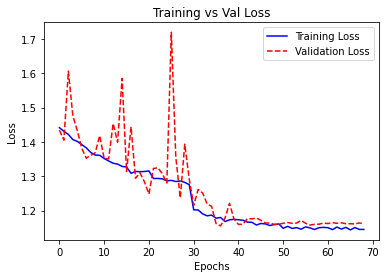

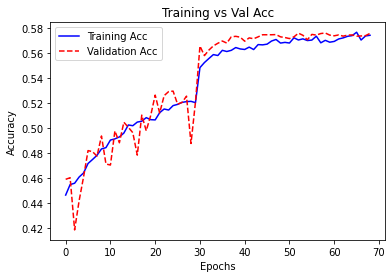

In [64]:
plot_results(CNN_v1_history)

CNN_v1_model.save('CNN_v1_250epochs.h5')

In [65]:
from sklearn.metrics import classification_report

In [66]:
def display_classifcation_report(model, test_dataflow):
    predictions = model.predict(test_dataflow)
    predictions = np.argmax(predictions, axis = -1)
    y_test = test_dataflow.labels
    print(classification_report(y_test, predictions, target_names = emotions))

In [67]:
display_classifcation_report(CNN_v1_model,test_dataflow)

              precision    recall  f1-score   support

       angry       0.45      0.53      0.49       958
     disgust       0.20      0.02      0.03       111
        fear       0.40      0.24      0.30      1024
       happy       0.84      0.81      0.82      1774
     neutral       0.47      0.70      0.56      1233
         sad       0.45      0.40      0.42      1247
    surprise       0.76      0.72      0.74       831

    accuracy                           0.58      7178
   macro avg       0.51      0.49      0.48      7178
weighted avg       0.57      0.58      0.57      7178



# Transfer Learning

## Inception

In [68]:
Incep_model = tf.keras.applications.InceptionV3(include_top=False)

In [69]:
Incep_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv2d_12 (Conv2D)             (None, None, None,   864         ['input_2[0][0]']                
                                32)                                                               
                                                                                                  
 batch_normalization_6 (BatchNo  (None, None, None,   96         ['conv2d_12[0][0]']              
 rmalization)                   32)                                                    

In [70]:
for layers in Incep_model.layers:
    layers.trainable = False

In [71]:
last_layer = Incep_model.get_layer('mixed10')

In [72]:
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, None, None, 2048)


In [73]:
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.Dense(1024, activation = 'relu')(x)
x = tf.keras.layers.Dropout(0.25)(x)
x = tf.keras.layers.Dense(7, activation = 'softmax')(x)

In [74]:
tl_Incept_model = tf.keras.models.Model(Incep_model.input, x)

In [75]:
tl_Incept_model.inputs

[<KerasTensor: shape=(None, None, None, 3) dtype=float32 (created by layer 'input_2')>]

In [76]:
tl_Incept_model.outputs

[<KerasTensor: shape=(None, 7) dtype=float32 (created by layer 'dense_9')>]

In [77]:
tl_Incept_model.compile(loss = 'categorical_crossentropy' , 
                        metrics = ['acc'],
                        optimizer = tf.keras.optimizers.Adam())

In [78]:
def to_grayscale_then_rgb(image):
    image = tf.image.rgb_to_grayscale(image)
    image = tf.image.grayscale_to_rgb(image)
    return image

In [80]:
train_rgb_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                    preprocessing_function= to_grayscale_then_rgb,
                                                                    #preprocessing_function=tf.image.grayscale_to_rgb,
                                                                    vertical_flip= True,
                                                                    rotation_range=5,
                                                                    width_shift_range=0.2,
                                                                    height_shift_range=0.2,
                                                                    shear_range=0.2,
                                                                    horizontal_flip=True,
                                                                    fill_mode='nearest')

train_dataflow_rgb = train_rgb_datagen.flow_from_directory(train_root,
                                                          target_size = (48,48,),
                                                          seed = seed_num)

test_rgb_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                   preprocessing_function= to_grayscale_then_rgb,
                                                                   #preprocessing_function=tf.image.grayscale_to_rgb,
                                                                   vertical_flip= True)

test_dataflow_rgb = test_rgb_datagen.flow_from_directory(test_root,
                                                          target_size = (48,48,),
                                                         shuffle = False,
                                                          seed = seed_num)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [27]:
#tl_Incept_model.load_weights('tl_Incept_model_epochs50.h5')

In [ ]:
epochs = 50
steps_per_epoch = 1000

tl_Incept_history = tl_Incept_model.fit(train_dataflow_rgb,
                                          epochs = epochs, 
                                          validation_data=(test_dataflow_rgb),
                                          #steps_per_epoch=steps_per_epoch,
                                          callbacks=[early_callback, myCallback])#, reduceLR])

Epoch 1/50


In [ ]:
plot_results(tl_Incept_history)

tl_Incept_model.save('tl_Incept_model_epochs50.h5')

In [ ]:
display_classifcation_report(tl_Incept_model, test_dataflow_rgb)

## ResNet

In [81]:
resnet = tf.keras.applications.resnet50.ResNet50(include_top= False)

resnet.summary()

In [82]:
for layer in resnet.layers:
    layer.trainable = False

In [83]:
inputs = resnet.input

In [84]:
last_layer = resnet.get_layer('conv5_block1_out')
last_output = last_layer.output
x = tf.keras.layers.GlobalAveragePooling2D()(last_output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dense(7, activation = 'softmax')(x)

tf_resnet_model = tf.keras.models.Model(inputs, x)

In [85]:
tf_resnet_model.compile(loss = 'categorical_crossentropy' , 
                        metrics = ['acc'],
                        optimizer = tf.keras.optimizers.Adam())

tf_resnet_model.load_weights('tf_resnet_model_epochs50.h5')

In [86]:
epochs = 50
steps_per_epoch = 1000

tf_resnet_history = tf_resnet_model.fit(train_dataflow_rgb, 
                                          epochs = epochs, 
                                          validation_data=(test_dataflow_rgb),
                                          #steps_per_epoch=steps_per_epoch,
                                          callbacks=[early_callback, myCallback,reduceLR])

Epoch 1/50
898/898 [==============================] - 218s 239ms/step - loss: 1.8941 - acc: 0.2333 - val_loss: 1.8197 - val_acc: 0.2471 - lr: 0.0010
Epoch 2/50
898/898 [==============================] - 198s 220ms/step - loss: 1.8131 - acc: 0.2509 - val_loss: 1.8130 - val_acc: 0.2471 - lr: 0.0010
Epoch 3/50
898/898 [==============================] - 192s 214ms/step - loss: 1.8105 - acc: 0.2513 - val_loss: 1.8089 - val_acc: 0.2474 - lr: 0.0010
Epoch 4/50
898/898 [==============================] - 187s 209ms/step - loss: 1.8103 - acc: 0.2511 - val_loss: 1.8125 - val_acc: 0.2469 - lr: 0.0010
Epoch 5/50
898/898 [==============================] - 194s 216ms/step - loss: 1.8094 - acc: 0.2512 - val_loss: 1.8054 - val_acc: 0.2471 - lr: 0.0010
Epoch 6/50
898/898 [==============================] - 147s 164ms/step - loss: 1.8072 - acc: 0.2512 - val_loss: 1.8003 - val_acc: 0.2491 - lr: 0.0010
Epoch 7/50
898/898 [==============================] - 166s 185ms/step - loss: 1.8063 - acc: 0.2517 - val_l

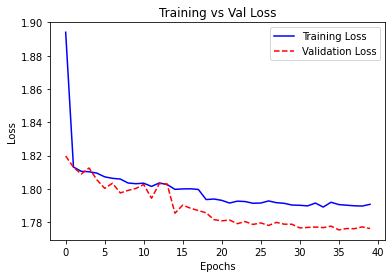

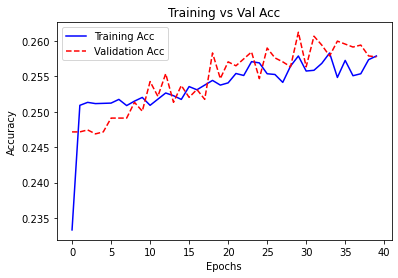

In [87]:
plot_results(tf_resnet_history)

tf_resnet_model.save('tf_resnet_model_epochs50.h5')

In [88]:
display_classifcation_report(tf_resnet_model,test_dataflow_rgb)

              precision    recall  f1-score   support

       angry       0.22      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.24      0.07      0.10      1024
       happy       0.26      0.93      0.41      1774
     neutral       0.00      0.00      0.00      1233
         sad       0.25      0.08      0.12      1247
    surprise       0.35      0.06      0.11       831

    accuracy                           0.26      7178
   macro avg       0.19      0.16      0.11      7178
weighted avg       0.21      0.26      0.15      7178



C:\Users\Randy\Venv\testpy39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Randy\Venv\testpy39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Randy\Venv\testpy39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# CNN model 2

In [89]:
CNN_v2_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3) , input_shape = (48,48,1), activation = 'relu'),
    tf.keras.layers.Conv2D(128, (3,3) , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3,3) , activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(512, (3,3) , activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

In [90]:
CNN_v2_model.compile(loss = 'categorical_crossentropy' , 
              metrics = ['acc'],
             optimizer = tf.keras.optimizers.RMSprop())

In [91]:
CNN_v2_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_106 (Conv2D)         (None, 46, 46, 64)        640       
                                                                 
 conv2d_107 (Conv2D)         (None, 44, 44, 128)       73856     
                                                                 
 batch_normalization_100 (Ba  (None, 44, 44, 128)      512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 22, 22, 128)      0         
 g2D)                                                            
                                                                 
 dropout_9 (Dropout)         (None, 22, 22, 128)       0         
                                                                 
 conv2d_108 (Conv2D)         (None, 20, 20, 256)      

CNN_v2_model.load_weights('CNN_v2_100epochs.h5')

In [92]:
epochs = 10
steps_per_epoch = 1000

CNN_v2_history = CNN_v2_model.fit(train_dataflow, 
                                  epochs = epochs, 
                                  validation_data=(test_dataflow),
                                  #steps_per_epoch=steps_per_epoch,
                                  callbacks=[early_callback, myCallback])

Epoch 1/10
898/898 [==============================] - 30s 31ms/step - loss: 2.5349 - acc: 0.2123 - val_loss: 1.9871 - val_acc: 0.2327
Epoch 2/10
898/898 [==============================] - 27s 30ms/step - loss: 2.0088 - acc: 0.2415 - val_loss: 2.0017 - val_acc: 0.2779
Epoch 3/10
898/898 [==============================] - 27s 30ms/step - loss: 1.9691 - acc: 0.2621 - val_loss: 2.0512 - val_acc: 0.2519
Epoch 4/10
898/898 [==============================] - 27s 30ms/step - loss: 1.9433 - acc: 0.2727 - val_loss: 1.9100 - val_acc: 0.3036
Epoch 5/10
898/898 [==============================] - 27s 30ms/step - loss: 1.9205 - acc: 0.2863 - val_loss: 1.8983 - val_acc: 0.3004
Epoch 6/10
898/898 [==============================] - 27s 30ms/step - loss: 1.9297 - acc: 0.3025 - val_loss: 2.1592 - val_acc: 0.2703
Epoch 7/10
898/898 [==============================] - 27s 30ms/step - loss: 1.9105 - acc: 0.3122 - val_loss: 2.4125 - val_acc: 0.2910
Epoch 8/10
898/898 [==============================] - 27s 30ms

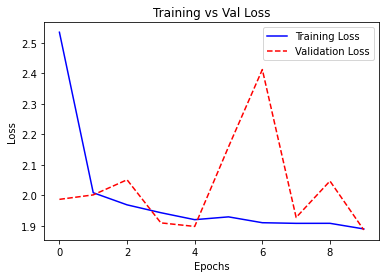

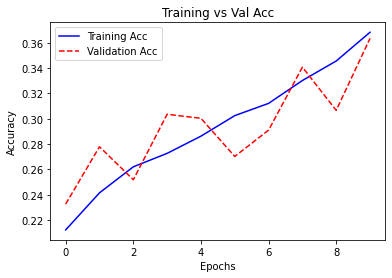

In [93]:
plot_results(CNN_v2_history)

This looks promising. We train for a further 90 epochs, totalling 100 epochs for this model

In [94]:
epochs = 100
steps_per_epoch = 1000

CNN_v2_history = CNN_v2_model.fit(train_dataflow, 
                                  epochs = epochs, 
                                  validation_data=(test_dataflow),
                                  initial_epoch = 10,
                                  #steps_per_epoch=steps_per_epoch,
                                  callbacks=[early_callback, myCallback])

Epoch 11/100
898/898 [==============================] - 27s 30ms/step - loss: 1.8607 - acc: 0.3772 - val_loss: 1.8504 - val_acc: 0.3975
Epoch 12/100
898/898 [==============================] - 27s 30ms/step - loss: 1.8666 - acc: 0.3796 - val_loss: 1.7809 - val_acc: 0.4182
Epoch 13/100
898/898 [==============================] - 27s 30ms/step - loss: 1.8357 - acc: 0.3911 - val_loss: 1.8542 - val_acc: 0.3940
Epoch 14/100
898/898 [==============================] - 27s 30ms/step - loss: 1.8540 - acc: 0.3977 - val_loss: 1.8987 - val_acc: 0.3863
Epoch 15/100
898/898 [==============================] - 27s 30ms/step - loss: 1.8038 - acc: 0.4038 - val_loss: 1.7060 - val_acc: 0.4517
Epoch 16/100
898/898 [==============================] - 27s 30ms/step - loss: 1.7868 - acc: 0.4091 - val_loss: 1.7596 - val_acc: 0.4048
Epoch 17/100
898/898 [==============================] - 27s 30ms/step - loss: 1.7730 - acc: 0.4208 - val_loss: 1.6884 - val_acc: 0.4507
Epoch 18/100
898/898 [==========================

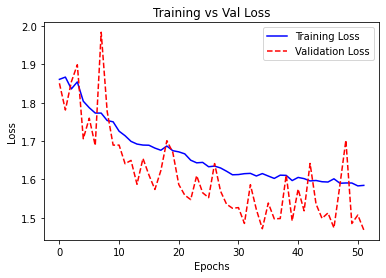

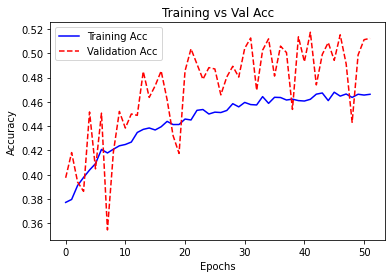

In [95]:
plot_results(CNN_v2_history)

In [96]:
display_classifcation_report(CNN_v2_model,test_dataflow)

              precision    recall  f1-score   support

       angry       0.39      0.38      0.39       958
     disgust       0.00      0.00      0.00       111
        fear       0.33      0.05      0.09      1024
       happy       0.73      0.75      0.74      1774
     neutral       0.47      0.55      0.51      1233
         sad       0.36      0.57      0.44      1247
    surprise       0.65      0.70      0.67       831

    accuracy                           0.52      7178
   macro avg       0.42      0.43      0.41      7178
weighted avg       0.50      0.52      0.49      7178



C:\Users\Randy\Venv\testpy39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Randy\Venv\testpy39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Randy\Venv\testpy39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CNN_v2_model.save('CNN_v2_100epochs.h5')

# CNN Version 3

In [97]:
CNN_v3_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3) , input_shape = (48,48,1), activation = 'relu'),
    tf.keras.layers.Conv2D(128, (3,3) , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3,3) , activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(512, (3,3) , activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

In [98]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 *10 **(epoch/20))

In [99]:
CNN_v3_model.compile(loss = 'categorical_crossentropy' , 
              metrics = ['acc'],
             optimizer = tf.keras.optimizers.Adam(learning_rate=1e-8))

In [100]:
CNN_v3_model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 46, 46, 64)        640       
                                                                 
 conv2d_111 (Conv2D)         (None, 44, 44, 128)       73856     
                                                                 
 batch_normalization_104 (Ba  (None, 44, 44, 128)      512       
 tchNormalization)                                               
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 22, 22, 128)      0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 22, 22, 128)       0         
                                                                 
 conv2d_112 (Conv2D)         (None, 20, 20, 256)      

Searching for optimal Learning rate

In [101]:
epochs = 100
steps_per_epoch = 1000

CNN_v3_history = CNN_v3_model.fit(train_dataflow, 
                                  epochs = epochs, 
                                  validation_data=(test_dataflow),
                                  #steps_per_epoch=steps_per_epoch,
                                  callbacks=[early_callback, myCallback, lr_schedule])

Epoch 1/100
898/898 [==============================] - 26s 28ms/step - loss: 7.9980 - acc: 0.1338 - val_loss: 7.8560 - val_acc: 0.0641 - lr: 1.0000e-08
Epoch 2/100
898/898 [==============================] - 25s 28ms/step - loss: 7.9894 - acc: 0.1324 - val_loss: 7.8476 - val_acc: 0.0660 - lr: 1.1220e-08
Epoch 3/100
898/898 [==============================] - 29s 32ms/step - loss: 7.9554 - acc: 0.1366 - val_loss: 7.8269 - val_acc: 0.0673 - lr: 1.2589e-08
Epoch 4/100
898/898 [==============================] - 25s 28ms/step - loss: 7.9460 - acc: 0.1359 - val_loss: 7.8032 - val_acc: 0.0692 - lr: 1.4125e-08
Epoch 5/100
898/898 [==============================] - 25s 28ms/step - loss: 7.9297 - acc: 0.1335 - val_loss: 7.7850 - val_acc: 0.0723 - lr: 1.5849e-08
Epoch 6/100
898/898 [==============================] - 25s 27ms/step - loss: 7.9047 - acc: 0.1376 - val_loss: 7.7539 - val_acc: 0.0755 - lr: 1.7783e-08
Epoch 7/100
898/898 [==============================] - 25s 28ms/step - loss: 7.8932 - ac

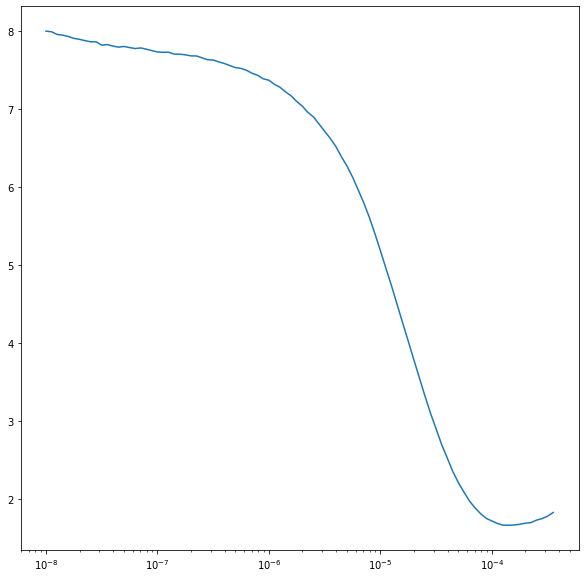

In [102]:
plt.figure(figsize = (10,10))
plt.semilogx(CNN_v3_history.history['lr'],CNN_v3_history.history['loss'])
plt.show()

Seems like the best learning rate to use is around 0.0001 to 0.0002 so lets pick 0.00015

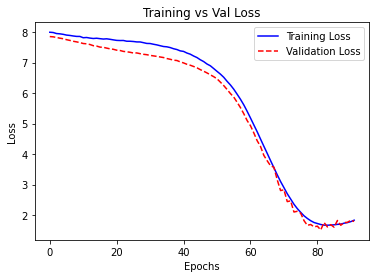

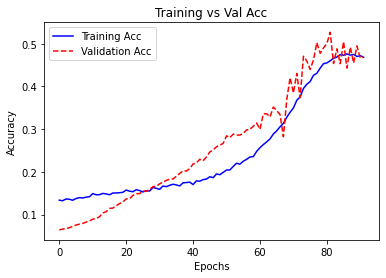

In [103]:
plot_results(CNN_v3_model.history)

In [104]:
CNN_v3a_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3) , input_shape = (48,48,1), activation = 'relu'),
    tf.keras.layers.Conv2D(128, (3,3) , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3,3) , activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(512, (3,3) , activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

CNN_v3a_model.load_weights('CNN_v3a_100epochs.h5')

In [105]:
CNN_v3a_model.compile(loss = 'categorical_crossentropy' , 
              metrics = ['acc'],
             optimizer = tf.keras.optimizers.Adam(learning_rate=15e-5))

In [106]:
epochs = 100
steps_per_epoch = 1000

CNN_v3a_history = CNN_v3a_model.fit(train_dataflow, 
                                  epochs = epochs, 
                                  validation_data=(test_dataflow),
                                  #steps_per_epoch=steps_per_epoch,
                                  callbacks=[early_callback, myCallback, reduceLR])

Epoch 1/100
898/898 [==============================] - 26s 28ms/step - loss: 5.9041 - acc: 0.2053 - val_loss: 4.3990 - val_acc: 0.2572 - lr: 1.5000e-04
Epoch 2/100
898/898 [==============================] - 25s 27ms/step - loss: 3.6317 - acc: 0.2348 - val_loss: 2.7769 - val_acc: 0.2733 - lr: 1.5000e-04
Epoch 3/100
898/898 [==============================] - 24s 27ms/step - loss: 2.4832 - acc: 0.2706 - val_loss: 2.9351 - val_acc: 0.1558 - lr: 1.5000e-04
Epoch 4/100
898/898 [==============================] - 25s 28ms/step - loss: 2.0571 - acc: 0.3069 - val_loss: 1.8209 - val_acc: 0.3770 - lr: 1.5000e-04
Epoch 5/100
898/898 [==============================] - 25s 27ms/step - loss: 1.8988 - acc: 0.3475 - val_loss: 1.8903 - val_acc: 0.3544 - lr: 1.5000e-04
Epoch 6/100
898/898 [==============================] - 25s 27ms/step - loss: 1.8090 - acc: 0.3846 - val_loss: 1.8834 - val_acc: 0.4016 - lr: 1.5000e-04
Epoch 7/100
898/898 [==============================] - 25s 28ms/step - loss: 1.7677 - ac

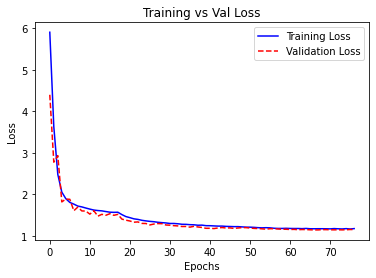

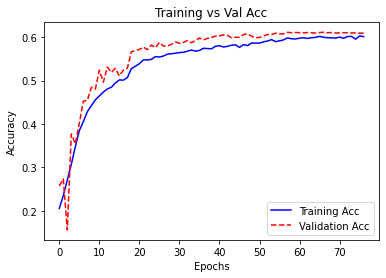

In [107]:
plot_results(CNN_v3a_history)

In [108]:
display_classifcation_report(CNN_v3a_model,test_dataflow)

              precision    recall  f1-score   support

       angry       0.52      0.53      0.53       958
     disgust       0.49      0.23      0.31       111
        fear       0.53      0.21      0.30      1024
       happy       0.83      0.85      0.84      1774
     neutral       0.50      0.71      0.59      1233
         sad       0.47      0.49      0.48      1247
    surprise       0.73      0.77      0.75       831

    accuracy                           0.61      7178
   macro avg       0.58      0.54      0.54      7178
weighted avg       0.61      0.61      0.60      7178



CNN_v3a_model.save('CNN_v3a_100epochs.h5')

In [109]:
CNN_v3a_model.compile(loss = 'categorical_crossentropy' , 
              metrics = ['acc'],
             optimizer = tf.keras.optimizers.Adam(learning_rate=1.5e-5))

Train more epochs and see if we get better results

In [110]:
epochs = 100
steps_per_epoch = 1000

CNN_v3a_history = CNN_v3a_model.fit(train_dataflow, 
                                  epochs = epochs, 
                                  validation_data=(test_dataflow),
                                  #steps_per_epoch=steps_per_epoch,
                                  callbacks=[early_callback, myCallback,reduceLR])

Epoch 1/100
898/898 [==============================] - 27s 29ms/step - loss: 1.4088 - acc: 0.5321 - val_loss: 1.4095 - val_acc: 0.5449 - lr: 1.5000e-04
Epoch 2/100
898/898 [==============================] - 27s 30ms/step - loss: 1.4825 - acc: 0.5214 - val_loss: 1.4719 - val_acc: 0.5348 - lr: 1.5000e-04
Epoch 3/100
898/898 [==============================] - 26s 29ms/step - loss: 1.4925 - acc: 0.5296 - val_loss: 1.5286 - val_acc: 0.5424 - lr: 1.5000e-04
Epoch 4/100
898/898 [==============================] - 26s 29ms/step - loss: 1.5145 - acc: 0.5271 - val_loss: 1.6322 - val_acc: 0.5032 - lr: 1.5000e-04
Epoch 5/100
898/898 [==============================] - 26s 29ms/step - loss: 1.5174 - acc: 0.5269 - val_loss: 1.5700 - val_acc: 0.5375 - lr: 1.5000e-04
Epoch 6/100
898/898 [==============================] - 26s 29ms/step - loss: 1.5251 - acc: 0.5227 - val_loss: 1.4856 - val_acc: 0.5443 - lr: 1.5000e-04
Epoch 7/100
898/898 [==============================] - 26s 29ms/step - loss: 1.4620 - ac

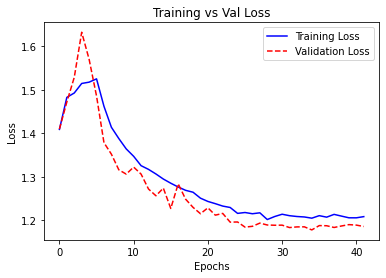

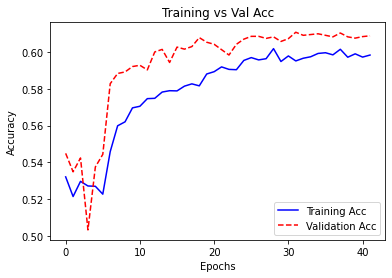

In [111]:
plot_results(CNN_v3a_history)

In [112]:
display_classifcation_report(CNN_v3a_model,test_dataflow)

              precision    recall  f1-score   support

       angry       0.52      0.54      0.53       958
     disgust       0.54      0.18      0.27       111
        fear       0.54      0.20      0.29      1024
       happy       0.83      0.84      0.84      1774
     neutral       0.50      0.72      0.59      1233
         sad       0.47      0.51      0.49      1247
    surprise       0.74      0.76      0.75       831

    accuracy                           0.61      7178
   macro avg       0.59      0.54      0.54      7178
weighted avg       0.61      0.61      0.60      7178



CNN_v3a_model.save('CNN_v3a_200epochs.h5')

## More Regularisation

In [113]:
CNN_v3b_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3) , input_shape = (48,48,1), activation = 'relu'),
    tf.keras.layers.Conv2D(128, (3,3) , activation = 'relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(256, (3,3) , activation = 'relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Conv2D(512, (3,3) , activation = 'relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

In [114]:
CNN_v3b_model.compile(loss = 'categorical_crossentropy' , 
              metrics = ['acc'],
             optimizer = tf.keras.optimizers.Adam(learning_rate=15e-5))

In [115]:
epochs = 100
steps_per_epoch = 1000

CNN_v3b_history = CNN_v3b_model.fit(train_dataflow, 
                                  epochs = epochs, 
                                  validation_data=(test_dataflow),
                                  #steps_per_epoch=steps_per_epoch,
                                  callbacks=[early_callback, myCallback, reduceLR])

Epoch 1/100
898/898 [==============================] - 28s 29ms/step - loss: 45.9149 - acc: 0.2037 - val_loss: 3.8199 - val_acc: 0.2549 - lr: 1.5000e-04
Epoch 2/100
898/898 [==============================] - 26s 29ms/step - loss: 2.9610 - acc: 0.2169 - val_loss: 2.5968 - val_acc: 0.2244 - lr: 1.5000e-04
Epoch 3/100
898/898 [==============================] - 26s 29ms/step - loss: 2.4213 - acc: 0.2240 - val_loss: 2.2449 - val_acc: 0.2449 - lr: 1.5000e-04
Epoch 4/100
898/898 [==============================] - 26s 29ms/step - loss: 2.2628 - acc: 0.2316 - val_loss: 2.0792 - val_acc: 0.2775 - lr: 1.5000e-04
Epoch 5/100
898/898 [==============================] - 25s 28ms/step - loss: 2.1495 - acc: 0.2441 - val_loss: 2.0776 - val_acc: 0.2666 - lr: 1.5000e-04
Epoch 6/100
898/898 [==============================] - 25s 28ms/step - loss: 2.1356 - acc: 0.2448 - val_loss: 2.1727 - val_acc: 0.2760 - lr: 1.5000e-04
Epoch 7/100
898/898 [==============================] - 26s 29ms/step - loss: 2.1462 - a

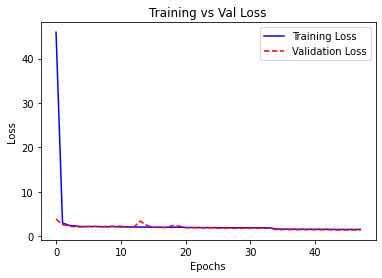

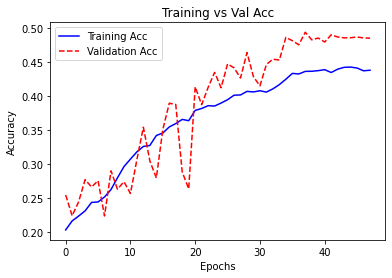

In [116]:
plot_results(CNN_v3b_history)

In [117]:
display_classifcation_report(CNN_v3b_model,test_dataflow)

              precision    recall  f1-score   support

       angry       0.38      0.28      0.32       958
     disgust       0.25      0.03      0.05       111
        fear       0.32      0.05      0.09      1024
       happy       0.73      0.77      0.75      1774
     neutral       0.38      0.58      0.46      1233
         sad       0.36      0.51      0.42      1247
    surprise       0.67      0.61      0.64       831

    accuracy                           0.49      7178
   macro avg       0.44      0.40      0.39      7178
weighted avg       0.48      0.49      0.47      7178



In [118]:
epochs = 100
steps_per_epoch = 1000

CNN_v3b_history = CNN_v3b_model.fit(train_dataflow, 
                                  epochs = epochs, 
                                  validation_data=(test_dataflow),
                                  #steps_per_epoch=steps_per_epoch,
                                  callbacks=[early_callback, myCallback,reduceLR])

Epoch 1/100
898/898 [==============================] - 78s 87ms/step - loss: 1.5174 - acc: 0.4363 - val_loss: 1.4069 - val_acc: 0.4886 - lr: 1.5000e-07
Epoch 2/100
898/898 [==============================] - 76s 84ms/step - loss: 1.5140 - acc: 0.4375 - val_loss: 1.4034 - val_acc: 0.4883 - lr: 1.5000e-07
Epoch 3/100
898/898 [==============================] - 75s 84ms/step - loss: 1.5164 - acc: 0.4334 - val_loss: 1.4036 - val_acc: 0.4879 - lr: 1.5000e-07
Epoch 4/100
898/898 [==============================] - 76s 84ms/step - loss: 1.5178 - acc: 0.4349 - val_loss: 1.4062 - val_acc: 0.4887 - lr: 1.5000e-07
Epoch 5/100
898/898 [==============================] - 75s 84ms/step - loss: 1.5145 - acc: 0.4379 - val_loss: 1.4024 - val_acc: 0.4882 - lr: 1.5000e-07
Epoch 6/100
898/898 [==============================] - 75s 84ms/step - loss: 1.5150 - acc: 0.4359 - val_loss: 1.4030 - val_acc: 0.4882 - lr: 1.5000e-07
Epoch 7/100
898/898 [==============================] - 75s 84ms/step - loss: 1.5148 - ac

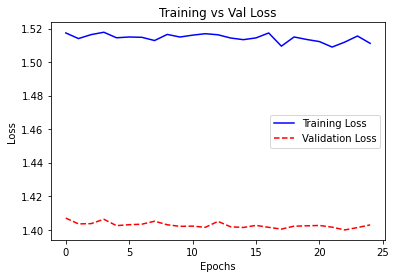

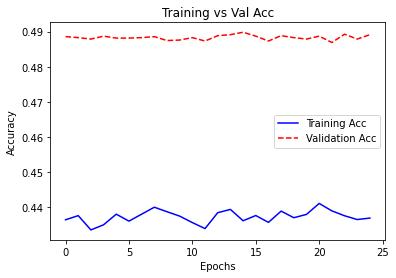

In [119]:
plot_results(CNN_v3b_history)

In [120]:
display_classifcation_report(CNN_v3b_model,test_dataflow)

              precision    recall  f1-score   support

       angry       0.41      0.22      0.29       958
     disgust       0.31      0.05      0.08       111
        fear       0.34      0.04      0.07      1024
       happy       0.68      0.81      0.74      1774
     neutral       0.36      0.61      0.45      1233
         sad       0.37      0.47      0.41      1247
    surprise       0.70      0.57      0.63       831

    accuracy                           0.49      7178
   macro avg       0.45      0.40      0.38      7178
weighted avg       0.48      0.49      0.46      7178



CNN_v3b_model.save('CNN_v3b_model_200epochs.h5')

## Even More regularisation

In [121]:
CNN_v3c_model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(64, (3,3) , input_shape = (48,48,1), activation = 'relu'),
    tf.keras.layers.Conv2D(128, (3,3) , activation = 'relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(256, (3,3) , activation = 'relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(512, (3,3) , activation = 'relu', kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.01)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.25),

    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Dense(7, activation='softmax')
])

In [122]:
CNN_v3c_model.compile(loss = 'categorical_crossentropy' , 
              metrics = ['acc'],
             optimizer = tf.keras.optimizers.Adam(learning_rate=15e-5))

In [123]:
epochs = 100
steps_per_epoch = 1000

CNN_v3c_history = CNN_v3c_model.fit(train_dataflow, 
                                  epochs = epochs, 
                                  validation_data=(test_dataflow),
                                  #steps_per_epoch=steps_per_epoch,
                                  callbacks=[early_callback, myCallback,reduceLR])

Epoch 1/100
898/898 [==============================] - 79s 85ms/step - loss: 55.5875 - acc: 0.1986 - val_loss: 5.2102 - val_acc: 0.2414 - lr: 1.5000e-04
Epoch 2/100
898/898 [==============================] - 77s 86ms/step - loss: 3.1746 - acc: 0.2154 - val_loss: 2.2534 - val_acc: 0.2480 - lr: 1.5000e-04
Epoch 3/100
898/898 [==============================] - 75s 84ms/step - loss: 2.2444 - acc: 0.2195 - val_loss: 2.0544 - val_acc: 0.2621 - lr: 1.5000e-04
Epoch 4/100
898/898 [==============================] - 75s 84ms/step - loss: 2.1954 - acc: 0.2225 - val_loss: 2.1262 - val_acc: 0.2118 - lr: 1.5000e-04
Epoch 5/100
898/898 [==============================] - 75s 84ms/step - loss: 2.2095 - acc: 0.2243 - val_loss: 2.0796 - val_acc: 0.2714 - lr: 1.5000e-04
Epoch 6/100
898/898 [==============================] - 78s 87ms/step - loss: 2.1920 - acc: 0.2326 - val_loss: 2.1006 - val_acc: 0.2506 - lr: 1.5000e-04
Epoch 7/100
898/898 [==============================] - 75s 84ms/step - loss: 2.1475 - a

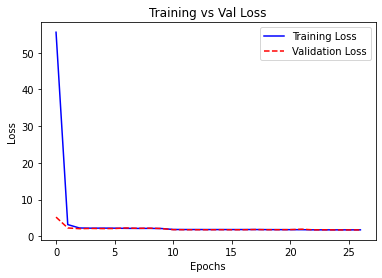

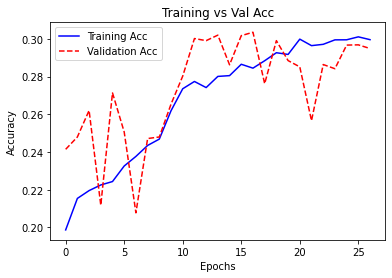

In [124]:
plot_results(CNN_v3c_history)

In [125]:
display_classifcation_report(CNN_v3c_model,test_dataflow)

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.32      0.03      0.05      1024
       happy       0.28      0.91      0.43      1774
     neutral       0.29      0.04      0.07      1233
         sad       0.35      0.03      0.05      1247
    surprise       0.40      0.54      0.46       831

    accuracy                           0.30      7178
   macro avg       0.24      0.22      0.15      7178
weighted avg       0.27      0.30      0.19      7178



C:\Users\Randy\Venv\testpy39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Randy\Venv\testpy39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Randy\Venv\testpy39\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CNN_v3c_model.save('CNN_v3c_model_100epochs.h5')

# Transfer Learning with Different Optimizer

## Inception

In [ ]:
tl_Incept_model.compile(loss = 'categorical_crossentropy' , 
                        metrics = ['acc'],
                        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
epochs = 50
steps_per_epoch = 1000

tl_Incept_history = tl_Incept_model.fit(train_dataflow_rgb,
                                          epochs = epochs, 
                                          validation_data=(test_dataflow_rgb),
                                          #steps_per_epoch=steps_per_epoch,
                                          callbacks=[early_callback, myCallback, reduceLR])

In [ ]:
plot_results(tl_Incept_history)

tl_Incept_model.save('tl_Incept_model_epochs100.h5')

In [ ]:
display_classifcation_report(tl_Incept_model,test_dataflow_rgb)

## ResNet

In [ ]:
tf_resnet_model.compile(loss = 'categorical_crossentropy' , 
                        metrics = ['acc'],
                        optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4))

In [ ]:
epochs = 50
steps_per_epoch = 1000

tf_resnet_history = tf_resnet_model.fit(train_dataflow_rgb, 
                                          epochs = epochs, 
                                          validation_data=(test_dataflow_rgb),
                                          #steps_per_epoch=steps_per_epoch,
                                          callbacks=[early_callback, myCallback, reduceLR])

In [ ]:
plot_results(tf_resnet_history)

tf_resnet_model.save('tf_resnet_model_epochs50.h5')

In [ ]:
display_classifcation_report(tf_resnet_model,test_dataflow_rgb)

## ResNet from Kaggle

In [126]:
base_model = tf.keras.applications.ResNet50(input_shape=(48,48,3),include_top=False,weights="imagenet")

In [127]:
# Freezing Layers

for layer in base_model.layers[:-4]:
    layer.trainable=False

In [131]:
# Building Model
model=tf.keras.models.Sequential()
model.add(base_model)
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dropout(0.5))
model.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.Activation('relu'))
model.add(tf.keras.layers.Dense(7,activation='softmax'))

In [132]:
# Model Summary

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2, 2, 2048)        23587712  
                                                                 
 dropout_29 (Dropout)        (None, 2, 2, 2048)        0         
                                                                 
 flatten_8 (Flatten)         (None, 8192)              0         
                                                                 
 batch_normalization_120 (Ba  (None, 8192)             32768     
 tchNormalization)                                               
                                                                 
 dense_22 (Dense)            (None, 32)                262176    
                                                                 
 batch_normalization_121 (Ba  (None, 32)               128       
 tchNormalization)                                    

In [140]:
lrd = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_acc',patience = 20,verbose = 1,factor = 0.50, min_lr = 1e-10)

mcp = tf.keras.callbacks.ModelCheckpoint('model.h5')

es = tf.keras.callbacks.EarlyStopping(verbose=1, patience=20)

In [134]:
model.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['acc'])

In [136]:
history=model.fit(train_dataflow_rgb,epochs = 60,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/60
898/898 [==============================] - ETA: 0s - loss: 1.8690 - acc: 0.2195WARNING:tensorflow:Learning rate reduction is conditioned on metric `val_loss` which is not available. Available metrics are: loss,acc,lr


C:\Users\Randy\Venv\testpy39\lib\site-packages\keras\engine\functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


898/898 [==============================] - 159s 176ms/step - loss: 1.8690 - acc: 0.2195 - lr: 0.0010
Epoch 2/60
898/898 [==============================] - 158s 176ms/step - loss: 1.8209 - acc: 0.2431 - lr: 0.0010
Epoch 3/60
898/898 [==============================] - 161s 179ms/step - loss: 1.8164 - acc: 0.2434 - lr: 0.0010
Epoch 4/60
898/898 [==============================] - 178s 199ms/step - loss: 1.8124 - acc: 0.2477 - lr: 0.0010
Epoch 5/60
898/898 [==============================] - 162s 181ms/step - loss: 1.8097 - acc: 0.2488 - lr: 0.0010
Epoch 6/60
898/898 [==============================] - 163s 181ms/step - loss: 1.8061 - acc: 0.2495 - lr: 0.0010
Epoch 7/60
898/898 [==============================] - 161s 180ms/step - loss: 1.8043 - acc: 0.2503 - lr: 0.0010
Epoch 8/60
898/898 [==============================] - 170s 189ms/step - loss: 1.8026 - acc: 0.2502 - lr: 0.0010
Epoch 9/60
898/898 [==============================] - 169s 189ms/step - loss: 1.7984 - acc: 0.2510 - lr: 0.0010
Epo

In [137]:
def plot_results(history):
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    acc = history.history['acc']
    val_acc  =history.history['val_acc']
    
    length = range(len(loss))
    
    plt.plot(length, loss, 'b' ,label = 'Training Loss')
    plt.plot(length, val_loss, 'r--', label = 'Validation Loss')
    plt.title('Training vs Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.figure()
    
    plt.plot(length, acc, 'b' ,label = 'Training Acc')
    plt.plot(length, val_acc, 'r--', label = 'Validation Acc')
    plt.title('Training vs Val Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [138]:
plot_results(history)

KeyError: 'val_loss'

In [ ]:
display_classifcation_report(model,test_dataflow)

In [139]:
train_dataflow_no_grayscale = train_dataGen.flow_from_directory(train_root,
                                                  target_size = (48,48),
                                                  seed = seed_num)

test_dataflow_no_grayscale = test_dataGen.flow_from_directory(test_root,
                                                target_size=(48,48),
                                                shuffle = False,
                                                seed = seed_num)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [143]:
# Building Model
model2=tf.keras.models.Sequential()
model2.add(base_model)
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Flatten())
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Activation('relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Activation('relu'))
model2.add(tf.keras.layers.Dropout(0.5))
model2.add(tf.keras.layers.Dense(32,kernel_initializer='he_uniform'))
model2.add(tf.keras.layers.BatchNormalization())
model2.add(tf.keras.layers.Activation('relu'))
model2.add(tf.keras.layers.Dense(7,activation='softmax'))

In [144]:
model2.compile(optimizer='Adam', loss='categorical_crossentropy',metrics=['acc'])

In [ ]:
history2=model2.fit(train_dataflow_rgb,epochs = 60,verbose = 1,callbacks=[lrd,mcp,es])

Epoch 1/60
898/898 [==============================] - 186s 202ms/step - loss: 1.8906 - acc: 0.2198 - lr: 0.0010
Epoch 2/60
898/898 [==============================] - 581s 648ms/step - loss: 1.8175 - acc: 0.2421 - lr: 0.0010
Epoch 3/60
898/898 [==============================] - 580s 643ms/step - loss: 1.8045 - acc: 0.2446 - lr: 0.0010
Epoch 4/60
898/898 [==============================] - 576s 642ms/step - loss: 1.7983 - acc: 0.2500 - lr: 0.0010
Epoch 5/60
898/898 [==============================] - 171s 190ms/step - loss: 1.7900 - acc: 0.2558 - lr: 0.0010
Epoch 6/60
898/898 [==============================] - 170s 190ms/step - loss: 1.7888 - acc: 0.2543 - lr: 0.0010
Epoch 7/60
898/898 [==============================] - 1090s 1s/step - loss: 1.7866 - acc: 0.2578 - lr: 0.0010
Epoch 8/60
898/898 [==============================] - 197s 219ms/step - loss: 1.7811 - acc: 0.2617 - lr: 0.0010
Epoch 9/60
898/898 [==============================] - 166s 185ms/step - loss: 1.7814 - acc: 0.2606 - lr: 0